<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

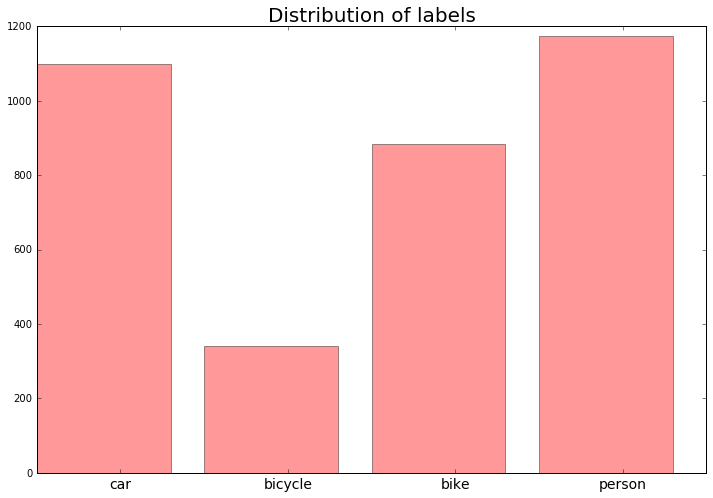

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, int(im.shape[1] * self.xi))
        yi = max(0, int(im.shape[0] * self.yi))
        xf = min(im.shape[1], int(im.shape[1] * self.xf))
        yf = min(im.shape[0], int(im.shape[0] * self.yf))
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [13]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.size, batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.size - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [14]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j]
                im = imread(objs[0]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = 1.
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .3 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [15]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [16]:
S = (7,7)
B = 2
C = 4

In [17]:
num_epochs = 1000
batch_size = 50

In [18]:
Xtest,ytest = [t for t in generate_data_2(train_annotations[:1], C, batch_size=batch_size)][0]
Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)

In [213]:
net = {}
net['input'] = InputLayer((None,3,200,200), input_var=Xtest)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (3,3))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))


net['dense1'] = DenseLayer(dropout(net['pool4'], p=.0), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.0), (2 * 5 + 4) * (7*7))
net['output'] = DenseLayer(dropout(net['dense2'], p=.0), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [206]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [214]:
net['output'] = net['dense2']
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [215]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [216]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.py'>

In [217]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [ ]:
cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

> /usr/local/python/bnr_ml/objectdetect/yolo.py(260)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) pred_w[0,0].eval()
array([[[ 0.97171628,  0.5       ,  0.96881008,  0.97108644,  0.97120172,
          0.97132325,  0.97075784],
        [ 0.9714812 ,  0.97087091,  0.97164607,  0.97198266,  0.97239518,
          0.97141796,  0.97112852],
        [ 0.5       ,  0.97224987,  0.9726336 ,  0.97133934,  0.96998399,
          0.97334981,  0.97172886],
        [ 0.96215624,  0.97219831,  0.9711284 ,  0.97068572,  0.97135949,
          0.96873301,  0.97178358],
        [ 0.97387516,  0.96691418,  0.97154367,  0.9719069 ,  0.96969044,
          0.97251004,  0.97108376],
        [ 0.9720661 ,  0.97180837,  0.97364986,  0.97130078,  0.96963924,
          0.97172087,  0.97282696],
        [ 0.97176039,  0.97173071,  0.5       ,  0.97144169,  0.96921921,
          0.97254169,  0.96974427]],

       [[ 0.97055769,  0.5    

In [211]:
train_loss, test_loss = yl.train(
    generate_data_2(train_annotations[:1], C, batch_size=batch_size),
    generate_data_2(test_annotations[:1], C, batch_size=batch_size),
    lr=1e-4,
    epochs=num_epochs
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(260)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(260)_get_cost_optim_multi()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) c
Creating cost variable took 2.2816 seconds
Compiling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling functions took 22.9872 seconds
Beginning training...
454.954925537
Epoch 0
------
Train Loss: 454.9549, Test Loss: 169.0661


  0%|          | 1/1000 [00:00<06:47,  2.45it/s]

189.689025879
Epoch 1
------
Train Loss: 189.6890, Test Loss: 168.0614


  0%|          | 2/1000 [00:00<06:22,  2.61it/s]

185.320724487
Epoch 2
------
Train Loss: 185.3207, Test Loss: 167.1252


  0%|          | 3/1000 [00:01<06:05,  2.73it/s]

182.900802612
Epoch 3
------
Train Loss: 182.9008, Test Loss: 166.1133


  0%|          | 4/1000 [00:01<05:53,  2.81it/s]

180.432846069
Epoch 4
------
Train Loss: 180.4328, Test Loss: 164.9594


  0%|          | 5/1000 [00:01<05:45,  2.88it/s]

177.680541992
Epoch 5
------
Train Loss: 177.6805, Test Loss: 163.4620


  1%|          | 6/1000 [00:02<05:40,  2.92it/s]

174.451934814
Epoch 6
------
Train Loss: 174.4519, Test Loss: 161.5810


  1%|          | 7/1000 [00:02<05:35,  2.96it/s]

170.51789856
Epoch 7
------
Train Loss: 170.5179, Test Loss: 159.0017


  1%|          | 8/1000 [00:02<05:32,  2.98it/s]

165.588699341
Epoch 8
------
Train Loss: 165.5887, Test Loss: 155.5093


  1%|          | 9/1000 [00:03<05:30,  3.00it/s]

159.315948486
Epoch 9
------
Train Loss: 159.3159, Test Loss: 150.6988


  1%|          | 10/1000 [00:03<05:27,  3.03it/s]

151.319259644
Epoch 10
------
Train Loss: 151.3193, Test Loss: 144.7785


  1%|          | 11/1000 [00:03<05:26,  3.03it/s]

141.570739746
Epoch 11
------
Train Loss: 141.5707, Test Loss: 136.9992


  1%|          | 12/1000 [00:04<05:24,  3.04it/s]

133.078201294
Epoch 12
------
Train Loss: 133.0782, Test Loss: 133.9059


  1%|▏         | 13/1000 [00:04<05:25,  3.03it/s]

132.109405518
Epoch 13
------
Train Loss: 132.1094, Test Loss: 123.5395


  1%|▏         | 14/1000 [00:04<05:26,  3.02it/s]

108.144981384
Epoch 14
------
Train Loss: 108.1450, Test Loss: 108.7600


  2%|▏         | 15/1000 [00:05<05:26,  3.02it/s]

92.6738433838
Epoch 15
------
Train Loss: 92.6738, Test Loss: 100.0292


  2%|▏         | 16/1000 [00:05<05:25,  3.02it/s]

79.1188735962
Epoch 16
------
Train Loss: 79.1189, Test Loss: 85.5291


  2%|▏         | 17/1000 [00:05<05:25,  3.02it/s]

70.9046783447
Epoch 17
------
Train Loss: 70.9047, Test Loss: 88.0285


  2%|▏         | 18/1000 [00:06<05:24,  3.03it/s]

81.9694824219
Epoch 18
------
Train Loss: 81.9695, Test Loss: 81.6531


  2%|▏         | 19/1000 [00:06<05:23,  3.03it/s]

58.6028785706
Epoch 19
------
Train Loss: 58.6029, Test Loss: 65.1712


  2%|▏         | 20/1000 [00:06<05:22,  3.04it/s]

49.8483161926
Epoch 20
------
Train Loss: 49.8483, Test Loss: 55.2826


  2%|▏         | 21/1000 [00:06<05:23,  3.03it/s]

44.4962654114
Epoch 21
------
Train Loss: 44.4963, Test Loss: 49.0909


  2%|▏         | 22/1000 [00:07<05:20,  3.05it/s]

41.0829772949
Epoch 22
------
Train Loss: 41.0830, Test Loss: 45.4642


  2%|▏         | 23/1000 [00:07<05:22,  3.03it/s]

39.0788269043
Epoch 23
------
Train Loss: 39.0788, Test Loss: 43.5132


  2%|▏         | 24/1000 [00:07<05:22,  3.03it/s]

37.7735404968
Epoch 24
------
Train Loss: 37.7735, Test Loss: 40.7430


  2%|▎         | 25/1000 [00:08<05:22,  3.03it/s]

36.8450927734
Epoch 25
------
Train Loss: 36.8451, Test Loss: 39.7098


  3%|▎         | 26/1000 [00:08<05:22,  3.02it/s]

36.2325935364
Epoch 26
------
Train Loss: 36.2326, Test Loss: 38.8372


  3%|▎         | 27/1000 [00:08<05:21,  3.03it/s]

35.8155136108
Epoch 27
------
Train Loss: 35.8155, Test Loss: 38.1549


  3%|▎         | 28/1000 [00:09<05:22,  3.02it/s]

35.5217132568
Epoch 28
------
Train Loss: 35.5217, Test Loss: 38.0252


  3%|▎         | 29/1000 [00:09<05:21,  3.02it/s]

35.4766960144
Epoch 29
------
Train Loss: 35.4767, Test Loss: 36.6885


  3%|▎         | 30/1000 [00:09<05:19,  3.04it/s]

35.3114395142
Epoch 30
------
Train Loss: 35.3114, Test Loss: 36.7908


  3%|▎         | 31/1000 [00:10<05:17,  3.05it/s]

35.1119117737
Epoch 31
------
Train Loss: 35.1119, Test Loss: 36.3951


  3%|▎         | 32/1000 [00:10<05:17,  3.05it/s]

35.0278015137
Epoch 32
------
Train Loss: 35.0278, Test Loss: 36.0758


  3%|▎         | 33/1000 [00:10<05:17,  3.04it/s]

34.936580658
Epoch 33
------
Train Loss: 34.9366, Test Loss: 35.9945


  3%|▎         | 34/1000 [00:11<05:16,  3.05it/s]

34.9298362732
Epoch 34
------
Train Loss: 34.9298, Test Loss: 35.2372


  4%|▎         | 35/1000 [00:11<05:17,  3.04it/s]

34.832901001
Epoch 35
------
Train Loss: 34.8329, Test Loss: 35.0107


  4%|▎         | 36/1000 [00:11<05:17,  3.04it/s]

34.7864227295
Epoch 36
------
Train Loss: 34.7864, Test Loss: 34.8114


  4%|▎         | 37/1000 [00:12<05:17,  3.03it/s]

34.7548065186
Epoch 37
------
Train Loss: 34.7548, Test Loss: 34.7448


  4%|▍         | 38/1000 [00:12<05:18,  3.02it/s]

34.7483100891
Epoch 38
------
Train Loss: 34.7483, Test Loss: 34.7955


  4%|▍         | 39/1000 [00:12<05:18,  3.02it/s]

34.6905403137
Epoch 39
------
Train Loss: 34.6905, Test Loss: 34.6461


  4%|▍         | 40/1000 [00:13<05:16,  3.04it/s]

34.6575622559
Epoch 40
------
Train Loss: 34.6576, Test Loss: 34.5204


  4%|▍         | 41/1000 [00:13<05:15,  3.04it/s]

34.6191864014
Epoch 41
------
Train Loss: 34.6192, Test Loss: 33.8749


  4%|▍         | 42/1000 [00:13<05:16,  3.03it/s]

34.5365486145
Epoch 42
------
Train Loss: 34.5365, Test Loss: 35.2019


  4%|▍         | 43/1000 [00:14<05:14,  3.04it/s]

33.7114372253
Epoch 43
------
Train Loss: 33.7114, Test Loss: 33.5918


  4%|▍         | 44/1000 [00:14<05:13,  3.05it/s]

33.4893951416
Epoch 44
------
Train Loss: 33.4894, Test Loss: 34.0786


  4%|▍         | 45/1000 [00:14<05:11,  3.06it/s]

33.162689209
Epoch 45
------
Train Loss: 33.1627, Test Loss: 33.7269


  5%|▍         | 46/1000 [00:15<05:12,  3.06it/s]

32.8903884888
Epoch 46
------
Train Loss: 32.8904, Test Loss: 32.3767


  5%|▍         | 47/1000 [00:15<05:12,  3.05it/s]

32.6979980469
Epoch 47
------
Train Loss: 32.6980, Test Loss: 32.1322


  5%|▍         | 48/1000 [00:15<05:11,  3.06it/s]

32.5901908875
Epoch 48
------
Train Loss: 32.5902, Test Loss: 31.7409


  5%|▍         | 49/1000 [00:16<05:12,  3.04it/s]

31.9378032684
Epoch 49
------
Train Loss: 31.9378, Test Loss: 31.4626


  5%|▌         | 50/1000 [00:16<05:13,  3.03it/s]

31.7355937958
Epoch 50
------
Train Loss: 31.7356, Test Loss: 31.2764


  5%|▌         | 51/1000 [00:16<05:13,  3.03it/s]

31.6271419525
Epoch 51
------
Train Loss: 31.6271, Test Loss: 31.2487


  5%|▌         | 52/1000 [00:17<05:12,  3.03it/s]

31.7813911438
Epoch 52
------
Train Loss: 31.7814, Test Loss: 31.3759


  5%|▌         | 53/1000 [00:17<05:10,  3.05it/s]

31.6349239349
Epoch 53
------
Train Loss: 31.6349, Test Loss: 31.5677


  5%|▌         | 54/1000 [00:17<05:11,  3.04it/s]

31.9581050873
Epoch 54
------
Train Loss: 31.9581, Test Loss: 31.2267


  6%|▌         | 55/1000 [00:18<05:11,  3.04it/s]

31.503900528
Epoch 55
------
Train Loss: 31.5039, Test Loss: 31.4930


  6%|▌         | 56/1000 [00:18<05:10,  3.04it/s]

31.7710647583
Epoch 56
------
Train Loss: 31.7711, Test Loss: 32.0966


  6%|▌         | 57/1000 [00:18<05:08,  3.05it/s]

31.5127906799
Epoch 57
------
Train Loss: 31.5128, Test Loss: 31.0968


  6%|▌         | 58/1000 [00:19<05:07,  3.07it/s]

31.7874565125
Epoch 58
------
Train Loss: 31.7875, Test Loss: 32.3593


  6%|▌         | 59/1000 [00:19<05:08,  3.05it/s]

31.4959506989
Epoch 59
------
Train Loss: 31.4960, Test Loss: 31.0381


  6%|▌         | 60/1000 [00:19<05:07,  3.06it/s]

31.4173336029
Epoch 60
------
Train Loss: 31.4173, Test Loss: 31.1217


  6%|▌         | 61/1000 [00:20<05:06,  3.06it/s]

31.5465679169
Epoch 61
------
Train Loss: 31.5466, Test Loss: 31.6435


  6%|▌         | 62/1000 [00:20<05:07,  3.05it/s]

31.429485321
Epoch 62
------
Train Loss: 31.4295, Test Loss: 31.0945


  6%|▋         | 63/1000 [00:20<05:07,  3.05it/s]

31.3864555359
Epoch 63
------
Train Loss: 31.3865, Test Loss: 31.1678


  6%|▋         | 64/1000 [00:21<05:05,  3.06it/s]

31.3660621643
Epoch 64
------
Train Loss: 31.3661, Test Loss: 31.1317


  6%|▋         | 65/1000 [00:21<05:05,  3.06it/s]

31.3535194397
Epoch 65
------
Train Loss: 31.3535, Test Loss: 31.1289


  7%|▋         | 66/1000 [00:21<05:05,  3.05it/s]

31.3447704315
Epoch 66
------
Train Loss: 31.3448, Test Loss: 31.1177


  7%|▋         | 67/1000 [00:22<05:04,  3.06it/s]

31.3380355835
Epoch 67
------
Train Loss: 31.3380, Test Loss: 31.1138


  7%|▋         | 68/1000 [00:22<05:06,  3.04it/s]

31.3325614929
Epoch 68
------
Train Loss: 31.3326, Test Loss: 31.1091


  7%|▋         | 69/1000 [00:22<05:06,  3.04it/s]

31.3279800415
Epoch 69
------
Train Loss: 31.3280, Test Loss: 31.1038


  7%|▋         | 70/1000 [00:23<05:06,  3.03it/s]

31.324092865
Epoch 70
------
Train Loss: 31.3241, Test Loss: 31.0983


  7%|▋         | 71/1000 [00:23<05:07,  3.02it/s]

31.3207740784
Epoch 71
------
Train Loss: 31.3208, Test Loss: 31.0940


  7%|▋         | 72/1000 [00:23<05:06,  3.03it/s]

31.3179283142
Epoch 72
------
Train Loss: 31.3179, Test Loss: 31.0897


  7%|▋         | 73/1000 [00:24<05:06,  3.02it/s]

31.3154850006
Epoch 73
------
Train Loss: 31.3155, Test Loss: 31.0861


  7%|▋         | 74/1000 [00:24<05:06,  3.02it/s]

31.3133850098
Epoch 74
------
Train Loss: 31.3134, Test Loss: 31.0825


  8%|▊         | 75/1000 [00:24<05:07,  3.01it/s]

31.3115921021
Epoch 75
------
Train Loss: 31.3116, Test Loss: 31.0793


  8%|▊         | 76/1000 [00:25<05:07,  3.01it/s]

31.3100700378
Epoch 76
------
Train Loss: 31.3101, Test Loss: 31.0764


  8%|▊         | 77/1000 [00:25<05:06,  3.01it/s]

31.3087940216
Epoch 77
------
Train Loss: 31.3088, Test Loss: 31.0739


  8%|▊         | 78/1000 [00:25<05:05,  3.01it/s]

31.3077354431
Epoch 78
------
Train Loss: 31.3077, Test Loss: 31.0712


  8%|▊         | 79/1000 [00:26<05:04,  3.02it/s]

31.3068771362
Epoch 79
------
Train Loss: 31.3069, Test Loss: 31.0701


  8%|▊         | 80/1000 [00:26<05:03,  3.03it/s]

31.3061885834
Epoch 80
------
Train Loss: 31.3062, Test Loss: 31.0655


  8%|▊         | 81/1000 [00:26<05:03,  3.03it/s]

31.3056430817
Epoch 81
------
Train Loss: 31.3056, Test Loss: 31.0697


  8%|▊         | 82/1000 [00:27<05:02,  3.03it/s]

31.3052177429
Epoch 82
------
Train Loss: 31.3052, Test Loss: 31.0538


  8%|▊         | 83/1000 [00:27<05:03,  3.02it/s]

31.3048858643
Epoch 83
------
Train Loss: 31.3049, Test Loss: 31.0890


  8%|▊         | 84/1000 [00:27<05:00,  3.05it/s]

31.3046569824
Epoch 84
------
Train Loss: 31.3047, Test Loss: 30.9869


  8%|▊         | 85/1000 [00:28<05:00,  3.04it/s]

31.3046913147
Epoch 85
------
Train Loss: 31.3047, Test Loss: 31.2923


  9%|▊         | 86/1000 [00:28<05:00,  3.04it/s]

31.3067779541
Epoch 86
------
Train Loss: 31.3068, Test Loss: 30.4046


  9%|▊         | 87/1000 [00:28<04:58,  3.06it/s]

31.330078125
Epoch 87
------
Train Loss: 31.3301, Test Loss: 33.9917


  9%|▉         | 88/1000 [00:29<04:57,  3.07it/s]

31.5767669678
Epoch 88
------
Train Loss: 31.5768, Test Loss: 39.4785


  9%|▉         | 89/1000 [00:29<04:56,  3.07it/s]

33.6339645386
Epoch 89
------
Train Loss: 33.6340, Test Loss: 41.9952


  9%|▉         | 90/1000 [00:29<04:57,  3.06it/s]

40.3710136414
Epoch 90
------
Train Loss: 40.3710, Test Loss: 33.4843


  9%|▉         | 91/1000 [00:30<04:56,  3.07it/s]

36.332195282
Epoch 91
------
Train Loss: 36.3322, Test Loss: 30.7604


  9%|▉         | 92/1000 [00:30<04:57,  3.05it/s]

31.0589923859
Epoch 92
------
Train Loss: 31.0590, Test Loss: 29.4282


  9%|▉         | 93/1000 [00:30<04:56,  3.06it/s]

30.4038124084
Epoch 93
------
Train Loss: 30.4038, Test Loss: 29.0676


  9%|▉         | 94/1000 [00:30<04:56,  3.05it/s]

30.0637054443
Epoch 94
------
Train Loss: 30.0637, Test Loss: 28.8630


 10%|▉         | 95/1000 [00:31<04:57,  3.04it/s]

29.8452281952
Epoch 95
------
Train Loss: 29.8452, Test Loss: 28.7448


 10%|▉         | 96/1000 [00:31<04:58,  3.03it/s]

29.6991767883
Epoch 96
------
Train Loss: 29.6992, Test Loss: 28.6760


 10%|▉         | 97/1000 [00:31<04:58,  3.02it/s]

29.5972881317
Epoch 97
------
Train Loss: 29.5973, Test Loss: 28.6365


 10%|▉         | 98/1000 [00:32<04:59,  3.01it/s]

29.5233459473
Epoch 98
------
Train Loss: 29.5233, Test Loss: 28.6131


 10%|▉         | 99/1000 [00:32<04:56,  3.04it/s]

29.4680538177
Epoch 99
------
Train Loss: 29.4681, Test Loss: 28.5975


 10%|█         | 100/1000 [00:32<04:55,  3.05it/s]

29.4257602692
Epoch 100
------
Train Loss: 29.4258, Test Loss: 28.5899


 10%|█         | 101/1000 [00:33<04:55,  3.04it/s]

29.3926849365
Epoch 101
------
Train Loss: 29.3927, Test Loss: 28.5859


 10%|█         | 102/1000 [00:33<04:55,  3.04it/s]

29.3663406372
Epoch 102
------
Train Loss: 29.3663, Test Loss: 28.5849


 10%|█         | 103/1000 [00:33<04:56,  3.03it/s]

29.3450965881
Epoch 103
------
Train Loss: 29.3451, Test Loss: 28.5853


 10%|█         | 104/1000 [00:34<04:55,  3.03it/s]

29.3277397156
Epoch 104
------
Train Loss: 29.3277, Test Loss: 28.5879


 10%|█         | 105/1000 [00:34<04:53,  3.05it/s]

29.3134002686
Epoch 105
------
Train Loss: 29.3134, Test Loss: 28.5916


 11%|█         | 106/1000 [00:34<04:52,  3.05it/s]

29.3014450073
Epoch 106
------
Train Loss: 29.3014, Test Loss: 28.5960


 11%|█         | 107/1000 [00:35<04:52,  3.05it/s]

29.291431427
Epoch 107
------
Train Loss: 29.2914, Test Loss: 28.6003


 11%|█         | 108/1000 [00:35<04:51,  3.06it/s]

29.2829685211
Epoch 108
------
Train Loss: 29.2830, Test Loss: 28.6056


 11%|█         | 109/1000 [00:35<04:52,  3.05it/s]

29.2757759094
Epoch 109
------
Train Loss: 29.2758, Test Loss: 28.6113


 11%|█         | 110/1000 [00:36<04:50,  3.06it/s]

29.2696266174
Epoch 110
------
Train Loss: 29.2696, Test Loss: 28.6177


 11%|█         | 111/1000 [00:36<04:51,  3.05it/s]

29.2643356323
Epoch 111
------
Train Loss: 29.2643, Test Loss: 28.6230


 11%|█         | 112/1000 [00:36<04:52,  3.03it/s]

29.2597732544
Epoch 112
------
Train Loss: 29.2598, Test Loss: 28.6280


 11%|█▏        | 113/1000 [00:37<04:52,  3.03it/s]

29.2558326721
Epoch 113
------
Train Loss: 29.2558, Test Loss: 28.6336


 11%|█▏        | 114/1000 [00:37<04:52,  3.02it/s]

29.252412796
Epoch 114
------
Train Loss: 29.2524, Test Loss: 28.6385


 12%|█▏        | 115/1000 [00:37<04:51,  3.04it/s]

29.2494335175
Epoch 115
------
Train Loss: 29.2494, Test Loss: 28.6445


 12%|█▏        | 116/1000 [00:38<04:52,  3.03it/s]

29.246837616
Epoch 116
------
Train Loss: 29.2468, Test Loss: 28.6489


 12%|█▏        | 117/1000 [00:38<04:50,  3.04it/s]

29.2445659637
Epoch 117
------
Train Loss: 29.2446, Test Loss: 28.6553


 12%|█▏        | 118/1000 [00:38<04:51,  3.03it/s]

29.2425765991
Epoch 118
------
Train Loss: 29.2426, Test Loss: 28.6581


 12%|█▏        | 119/1000 [00:39<04:49,  3.05it/s]

29.2408275604
Epoch 119
------
Train Loss: 29.2408, Test Loss: 28.6663


 12%|█▏        | 120/1000 [00:39<04:48,  3.05it/s]

29.2392921448
Epoch 120
------
Train Loss: 29.2393, Test Loss: 28.6646


 12%|█▏        | 121/1000 [00:39<04:49,  3.04it/s]

29.2379455566
Epoch 121
------
Train Loss: 29.2379, Test Loss: 28.6810


 12%|█▏        | 122/1000 [00:40<04:48,  3.04it/s]

29.2367630005
Epoch 122
------
Train Loss: 29.2368, Test Loss: 28.6596


 12%|█▏        | 123/1000 [00:40<04:48,  3.04it/s]

29.235742569
Epoch 123
------
Train Loss: 29.2357, Test Loss: 28.7223


 12%|█▏        | 124/1000 [00:40<04:47,  3.04it/s]

29.234954834
Epoch 124
------
Train Loss: 29.2350, Test Loss: 28.5845


 12%|█▎        | 125/1000 [00:41<04:48,  3.03it/s]

29.2350120544
Epoch 125
------
Train Loss: 29.2350, Test Loss: 28.9671


 13%|█▎        | 126/1000 [00:41<04:49,  3.02it/s]

29.2404251099
Epoch 126
------
Train Loss: 29.2404, Test Loss: 28.0264


 13%|█▎        | 127/1000 [00:41<04:48,  3.03it/s]

29.2867698669
Epoch 127
------
Train Loss: 29.2868, Test Loss: 30.8625


 13%|█▎        | 128/1000 [00:42<04:48,  3.02it/s]

29.5488433838
Epoch 128
------
Train Loss: 29.5488, Test Loss: 27.5093


 13%|█▎        | 129/1000 [00:42<04:46,  3.04it/s]

30.1718158722
Epoch 129
------
Train Loss: 30.1718, Test Loss: 28.1214


 13%|█▎        | 130/1000 [00:42<04:46,  3.04it/s]

29.2577152252
Epoch 130
------
Train Loss: 29.2577, Test Loss: 29.3069


 13%|█▎        | 131/1000 [00:43<04:45,  3.04it/s]

29.2743988037
Epoch 131
------
Train Loss: 29.2744, Test Loss: 27.6961


 13%|█▎        | 132/1000 [00:43<04:46,  3.03it/s]

29.3525390625
Epoch 132
------
Train Loss: 29.3525, Test Loss: 30.1605


 13%|█▎        | 133/1000 [00:43<04:47,  3.02it/s]

29.406211853
Epoch 133
------
Train Loss: 29.4062, Test Loss: 27.2928


 13%|█▎        | 134/1000 [00:44<04:46,  3.03it/s]

29.7079124451
Epoch 134
------
Train Loss: 29.7079, Test Loss: 29.4788


 14%|█▎        | 135/1000 [00:44<04:45,  3.03it/s]

29.3065891266
Epoch 135
------
Train Loss: 29.3066, Test Loss: 27.5178


 14%|█▎        | 136/1000 [00:44<04:45,  3.02it/s]

29.4128303528
Epoch 136
------
Train Loss: 29.4128, Test Loss: 29.9033


 14%|█▎        | 137/1000 [00:45<04:45,  3.03it/s]

29.3796253204
Epoch 137
------
Train Loss: 29.3796, Test Loss: 27.3216


 14%|█▍        | 138/1000 [00:45<04:42,  3.05it/s]

29.5911941528
Epoch 138
------
Train Loss: 29.5912, Test Loss: 29.5728


 14%|█▍        | 139/1000 [00:45<04:42,  3.05it/s]

29.3333187103
Epoch 139
------
Train Loss: 29.3333, Test Loss: 27.4152


 14%|█▍        | 140/1000 [00:46<04:42,  3.05it/s]

29.4628486633
Epoch 140
------
Train Loss: 29.4628, Test Loss: 29.6593


 14%|█▍        | 141/1000 [00:46<04:43,  3.03it/s]

29.3562736511
Epoch 141
------
Train Loss: 29.3563, Test Loss: 27.3548


 14%|█▍        | 142/1000 [00:46<04:42,  3.03it/s]

29.5174713135
Epoch 142
------
Train Loss: 29.5175, Test Loss: 29.5457


 14%|█▍        | 143/1000 [00:47<04:43,  3.02it/s]

29.3470630646
Epoch 143
------
Train Loss: 29.3471, Test Loss: 27.3712


 14%|█▍        | 144/1000 [00:47<04:41,  3.04it/s]

29.4866714478
Epoch 144
------
Train Loss: 29.4867, Test Loss: 29.5161


 14%|█▍        | 145/1000 [00:47<04:41,  3.03it/s]

29.3500518799
Epoch 145
------
Train Loss: 29.3501, Test Loss: 27.3570


In [212]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [ ]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

In [ ]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [ ]:
gen = generate_data_2(train_annotations[:1], C, max_objs=1)

In [ ]:
testdat = [t for t in gen]

In [ ]:
Xtest, ytest = testdat[0]

In [ ]:
out_fn = theano.function([yl.input], yl.output_test)

In [ ]:
Xtest_out = out_fn(Xtest)

In [ ]:
def draw_coord(im, coord, idx):
#     xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
#     yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xi = int(im.shape[1] * coord[0])
    yi = int(im.shape[0] * coord[1])
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)
    
    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    return draw_im

In [ ]:
def draw_best(im, output, num=None, thresh=.3):
    im = np.copy(im)
    objectness = output[[4,9]] * output[-C:].max()
    isgreater = objectness[objectness > thresh].size
    idxs = objectness.flatten().argsort()[::-1]
    for i in range(1):
        idx = idxs[i]
        idx = np.unravel_index(idx, objectness.shape)
        coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
        im = draw_coord(im, coord, idx)
        
    print objectness.max()
    print objectness[np.unravel_index(idxs[0], objectness.shape)]
    return im
        

In [ ]:
def draw_best_one(im, output):
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [ ]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [ ]:
tmp = Xtest_out

In [ ]:
tmp.shape

In [ ]:
tmp[0,:,0,1]

In [ ]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [ ]:
N = int(Xtest.shape[0] * np.random.rand())
# N = 20
print N
a = draw_best(swap(Xtest[N]), Xtest_out[N], thresh=.2)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(a)
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)